In [1]:
from sqldb import QueryDB

In [2]:
db = QueryDB()

## 1. Transaction Volume Over Time

In [3]:
qry = """
SELECT strftime('%Y', POSTED_DATE) AS year, COUNT(*) AS transaction_count, ACCOUNT_TYPE
FROM TRAn
GROUP BY year,ACCOUNT_TYPE
ORDER BY year,ACCOUNT_TYPE;
"""
db.execute(qry)

,year,transaction_count,ACCOUNT_TYPE
0,2021,1,CD
1,2021,18006,Checking
2,2021,208,Loan
3,2021,321,Savings
4,2022,8,CD
5,2022,32720,Checking
6,2022,380,Loan
7,2022,605,Savings
8,2023,8,CD
9,2023,35781,Checking


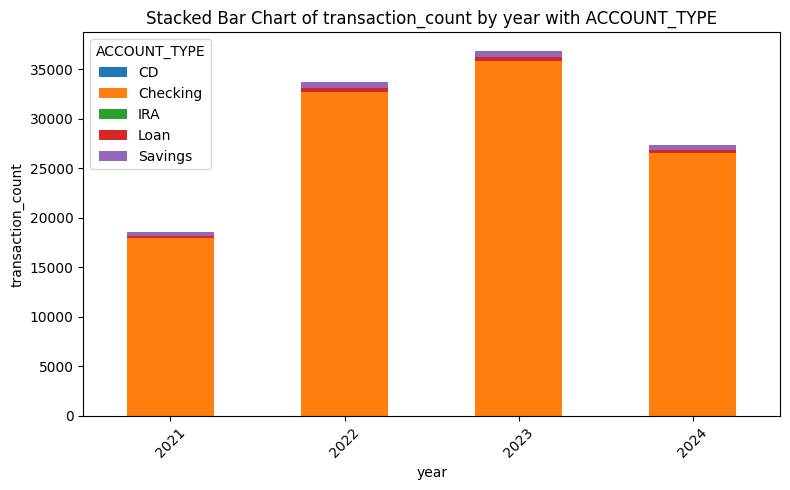

In [4]:
db.plot_stacked_bar(qry, "year", "transaction_count", "ACCOUNT_TYPE")

`Insights:`
- **The data shows overall growth in transactions for checking and savings accounts from 2021 to 2024, suggesting a positive trend in customer engagement**

## 2. Engagement Score

In [5]:
qry = """
SELECT 
    CUSTOMER_ID,
    COUNT(*) AS transaction_count,
    COALESCE(SUM(TRANSACTION_AMOUNT), 0) AS total_amount,
    (COUNT(*) * 0.5 + COALESCE(SUM(TRANSACTION_AMOUNT), 0) * 0.5) AS engagement_score
FROM 
    TRAN
GROUP BY 
    CUSTOMER_ID
HAVING 
    COUNT(*) > 0
ORDER BY 
    engagement_score DESC
LIMIT 10;
"""
db.execute(qry)

,CUSTOMER_ID,transaction_count,total_amount,engagement_score
0,9817178,3,48446630.16,2.422332e+07
1,6059066,3,44921764.99,2.246088e+07
2,8325927,4,36245303.44,1.812265e+07
3,4199470,1,25068811.91,1.253441e+07
4,9997760,5,20013809.98,1.000691e+07
5,1561357,3,14631934.09,7.315969e+06
6,8069717,1,13182000.51,6.591001e+06
7,116624,1,10871465.89,5.435733e+06
8,31741169,1,8400000.00,4.200000e+06
9,33131851,5,7970742.53,3.985374e+06


`Insights:`
- **Customers like 9817178 and 6059066 are top spenders with multiple transactions, indicating strong engagement**

## 3. Customer segmentation

In [6]:
qry = """
SELECT segment, COUNT(CUSTOMER_ID) AS customer_count
FROM (
    SELECT CUSTOMER_ID,
           CASE 
               WHEN SUM(TRANSACTION_AMOUNT) > 1000 THEN 'High Spender'
               WHEN COUNT(*) > 20 THEN 'Frequent Shopper'
               ELSE 'Occasional User'
           END AS segment
    FROM TRAN
    GROUP BY CUSTOMER_ID
) AS segments
GROUP BY segment;
"""
db.execute(qry)

,segment,customer_count
0,Frequent Shopper,1
1,High Spender,11546
2,Occasional User,62127


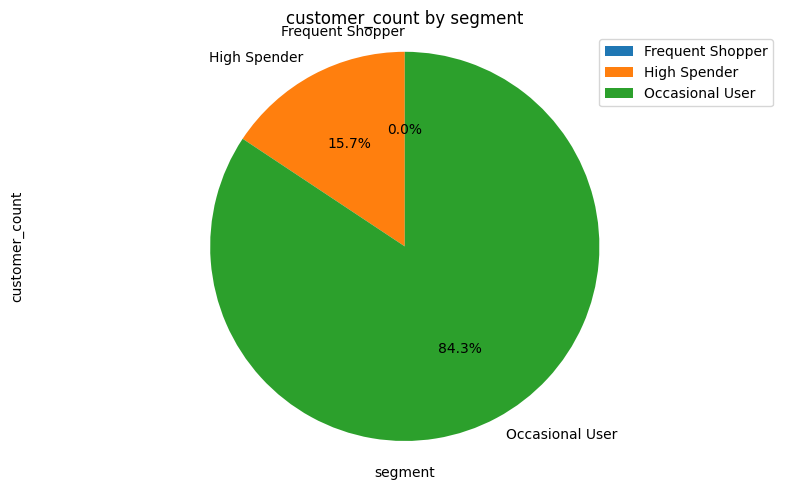

In [7]:
db.plot(qry,"segment","customer_count", "pie")

`Insights:`
- **The majority of customers are occasional users, with a large subset also considered high spenders**
- **This insight can help in tailoring marketing strategies for different customer segments**

## 4. Anamoly Detection: Large Transactions

Identifies transactions that exceed a certain threshold—typically defined as being more than three standard deviations above the average transaction amount.

In [8]:
qry = """
WITH transaction_stats AS (
    SELECT 
        AVG(TRANSACTION_AMOUNT) AS avg_amount,
        (SUM(TRANSACTION_AMOUNT * TRANSACTION_AMOUNT) / COUNT(*) - 
         (AVG(TRANSACTION_AMOUNT) * AVG(TRANSACTION_AMOUNT))) AS variance
    FROM TRAN
)
SELECT 
    CUSTOMER_ID,
    ACCOUNT_ID,
    account_type,
    TRANSACTION_ID,
    TRANSACTION_AMOUNT,
    EXTERNAL_CATEGORY,
    strftime('%Y-%m', POSTED_DATE) AS posted_month
FROM TRAN, transaction_stats
WHERE TRANSACTION_AMOUNT > (avg_amount + 3 * SQRT(variance));
"""
db.execute(qry)

,CUSTOMER_ID,ACCOUNT_ID,ACCOUNT_TYPE,TRANSACTION_ID,TRANSACTION_AMOUNT,EXTERNAL_CATEGORY,posted_month
0,31205909,8502414,Checking,1041228978,1050649.55,None,2024-06
1,6059066,1218502,Checking,1260640073,44893478.30,None,2022-10
2,2663369,3541991,Checking,1260664425,1704332.95,None,2024-08
3,31922079,8759787,Checking,81472231,2114400.00,None,2023-08
4,9817178,3865981,Checking,722439991,48444940.80,None,2023-09
...,...,...,...,...,...,...,...
97,31744822,8069843,Checking,2992251528,2044502.23,None,2021-09
98,8095914,3653874,Checking,390916429,1901200.23,None,2022-02
99,3779982,1739061,Checking,390930828,1462633.39,None,2023-07
100,9038767,923470,Savings,2453235973,2969946.45,None,2022-07


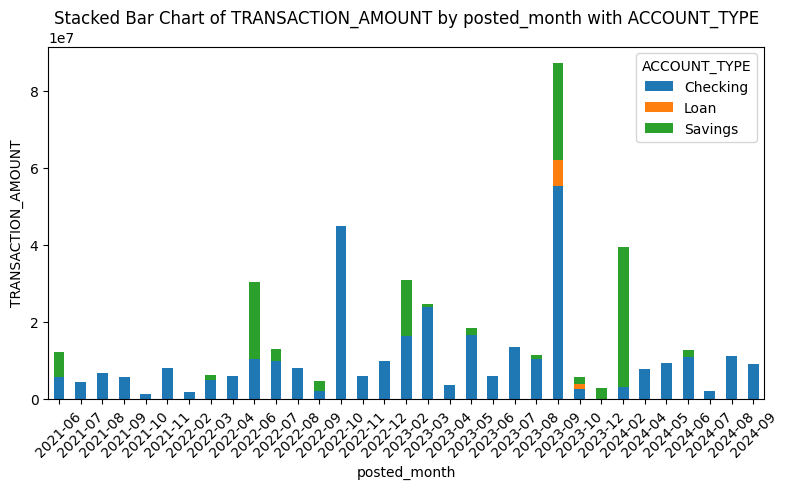

In [9]:
db.plot_stacked_bar(qry, "posted_month", "TRANSACTION_AMOUNT", "ACCOUNT_TYPE")

`Insights:`
- **Cross-Selling Opportunities: Engaging customers with high-value transactions can lead to potential cross-selling or upselling of financial products**
- **Varied Banking Habits: The presence of both "Checking" and "Savings" accounts suggests diverse banking behaviors among customers**

## 5. Spending Pattern Analysis

__a. Monthly and Overall spending__

In [10]:
qry = """
WITH Monthly_Spending AS (
    SELECT 
        strftime('%Y-%m', POSTED_DATE) AS month,
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0  -- Assuming negative values represent spending
    GROUP BY month, ACCOUNT_TYPE
),


Overall_Spending AS (
    SELECT 
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0
    GROUP BY ACCOUNT_TYPE
)

SELECT 
    'Monthly Analysis' AS analysis_type,
    month,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Monthly_Spending
UNION ALL

SELECT 
    'Overall Analysis' AS analysis_type,
    NULL AS month_or_year,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Overall_Spending
ORDER BY analysis_type, month_or_year, ACCOUNT_TYPE
;
"""
db.execute(qry)

,analysis_type,month,ACCOUNT_TYPE,total_spent,transaction_count
0,Monthly Analysis,2021-06,Checking,-397981.83,1106
1,Monthly Analysis,2021-06,Loan,-7189.21,6
2,Monthly Analysis,2021-06,Savings,-7639.79,26
3,Monthly Analysis,2021-07,Checking,-393067.46,999
4,Monthly Analysis,2021-07,Loan,-73.22,2
...,...,...,...,...,...
118,Monthly Analysis,2024-09,Savings,-9344.77,23
119,Overall Analysis,None,CD,-7000.00,2
120,Overall Analysis,None,Checking,-39089592.98,45566
121,Overall Analysis,None,Loan,-921098.26,134


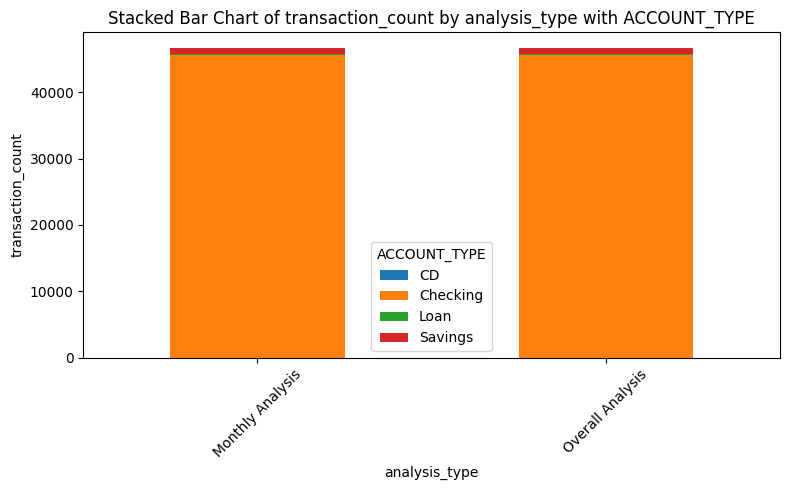

In [11]:
db.plot_stacked_bar(qry,"analysis_type","transaction_count", "ACCOUNT_TYPE")

`Insights:`
- **Monthly : Loan transactions, though fewer, indicate ongoing borrowing behavior among customers**
- **Overall : Loans contribute less to total spending but reflect significant borrowing activity**

__b. Yearly Spending__

In [12]:
qry = """
with Yearly_Spending AS (
    SELECT 
        strftime('%Y', POSTED_DATE) AS year,
        ACCOUNT_TYPE,
        SUM(TRANSACTION_AMOUNT) AS total_spent,
        COUNT(*) AS transaction_count
    FROM TRAN
    WHERE TRANSACTION_AMOUNT < 0
    GROUP BY year, ACCOUNT_TYPE
)

SELECT 
    'Yearly Analysis' AS analysis_type,
    year,
    ACCOUNT_TYPE,
    total_spent,
    transaction_count
FROM Yearly_Spending;
"""
db.execute(qry)

,analysis_type,year,ACCOUNT_TYPE,total_spent,transaction_count
0,Yearly Analysis,2021,Checking,-2804136.91,7222
1,Yearly Analysis,2021,Loan,-29795.61,22
2,Yearly Analysis,2021,Savings,-624030.17,145
3,Yearly Analysis,2022,CD,-7000.00,2
4,Yearly Analysis,2022,Checking,-24396609.13,12808
5,Yearly Analysis,2022,Loan,-394271.95,38
6,Yearly Analysis,2022,Savings,-144799.33,264
7,Yearly Analysis,2023,Checking,-6583458.11,14222
8,Yearly Analysis,2023,Loan,-439553.63,40
9,Yearly Analysis,2023,Savings,-166278.04,301


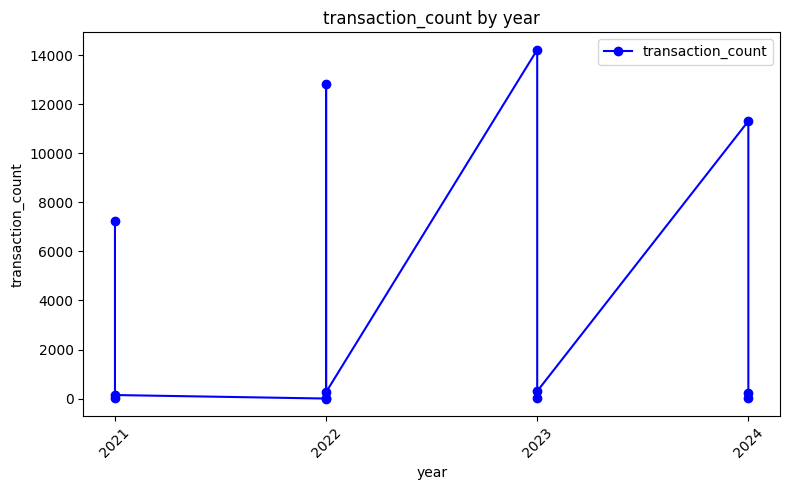

In [13]:
db.plot(qry,"year", "transaction_count", "line")

`Insights:`
- **The Checking account consistently shows the highest total spending across all years, especially in 2022, which stands out with over $24 million spent**

## 6. Join Two Tables

__a. Inactive customers from the Customer Table from the given data__

In [14]:
qry = """
SELECT 
    I.CUSTOMER_ID,
    I.CUSTOMER_JOIN_DATE,
    I.LAST_LOGIN_DATE
FROM 
    INFO I
LEFT JOIN 
    TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
GROUP BY 
    I.CUSTOMER_ID
HAVING 
    COUNT(T.TRANSACTION_ID) = 0 OR 
    MAX(T.POSTED_DATE) < DATE('now', '-1 year');
"""
db.execute(qry)

,CUSTOMER_ID,CUSTOMER_JOIN_DATE,LAST_LOGIN_DATE
0,7,2023-04-17,2024-08-08
1,32,2022-12-30,2022-12-30
2,129,2023-06-06,2024-10-03
3,185,2021-10-12,2024-09-26
4,225,2023-03-04,2024-10-11
...,...,...,...
138017,38799188,2024-09-17,2024-10-14
138018,38799191,2024-09-23,2024-10-14
138019,38799381,2024-09-17,2024-10-10
138020,38799561,2024-09-24,2024-10-04


`Insights:`
- The variance in last login dates suggests that some customers are highly engaged while others are not. 

__b. State-wise Spending Analysis__

In [22]:
qry = """
SELECT 
    I.STATE,
    SUM(T.TRANSACTION_AMOUNT) AS TOTAL_SPENDING,
    COUNT(DISTINCT I.CUSTOMER_ID) AS NUMBER_OF_CUSTOMERS
FROM 
    INFO I
LEFT JOIN 
    TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
GROUP BY 
    I.STATE
ORDER BY 
    TOTAL_SPENDING DESC
"""
db.execute(qry)

,STATE,TOTAL_SPENDING,NUMBER_OF_CUSTOMERS
0,TN,1.586944e+08,58136
1,NY,6.118980e+07,1970
2,SC,3.087702e+07,9539
3,NC,2.242139e+07,25823
4,TX,1.567789e+07,2635
5,GA,1.239997e+07,4478
6,VA,9.482759e+06,4875
7,MD,3.184639e+06,783
8,CA,1.616574e+06,3258
9,AL,1.084001e+06,19583


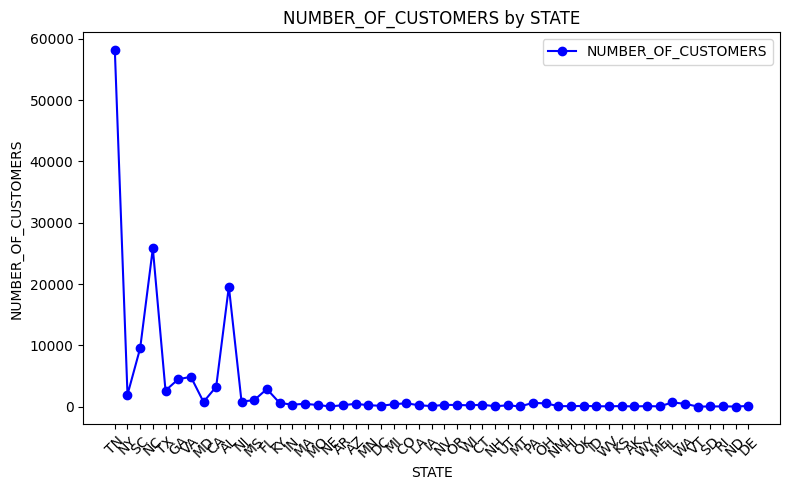

In [25]:
db.plot(qry,"STATE","NUMBER_OF_CUSTOMERS", "line")

`Insights:`
- **Tennessee (TN) leads with total spending of approximately $158.7 million from 58,136 customers, indicating a strong customer base.**
- **Strong Presence in the Southeast**

__c. Customer segmentation__

In [16]:
qry = """
SELECT 
    CUSTOMER_TYPE,
    CUSTOMER_SEGMENT,
    COUNT(DISTINCT CUSTOMER_ID) AS NUMBER_OF_CUSTOMERS
FROM (
    SELECT 
        I.CUSTOMER_ID,
        I.CUSTOMER_TYPE,
        SUM(T.TRANSACTION_AMOUNT) AS TOTAL_SPENT,
        CASE 
            WHEN SUM(T.TRANSACTION_AMOUNT) >= 1000 THEN 'High Value'
            WHEN SUM(T.TRANSACTION_AMOUNT) BETWEEN 500 AND 999 THEN 'Medium Value'
            ELSE 'Low Value'
        END AS CUSTOMER_SEGMENT
    FROM 
        INFO I
    LEFT JOIN 
        TRAN T ON I.CUSTOMER_ID = T.CUSTOMER_ID
    GROUP BY 
        I.CUSTOMER_ID, I.CUSTOMER_TYPE
) AS Subquery
GROUP BY 
    CUSTOMER_TYPE, CUSTOMER_SEGMENT
ORDER BY 
    CUSTOMER_TYPE, CUSTOMER_SEGMENT;
"""
db.execute(qry)

,CUSTOMER_TYPE,CUSTOMER_SEGMENT,NUMBER_OF_CUSTOMERS
0,Commercial,High Value,2875
1,Commercial,Low Value,50981
2,Commercial,Medium Value,609
3,Retail,High Value,502
4,Retail,Low Value,89777
5,Retail,Medium Value,256


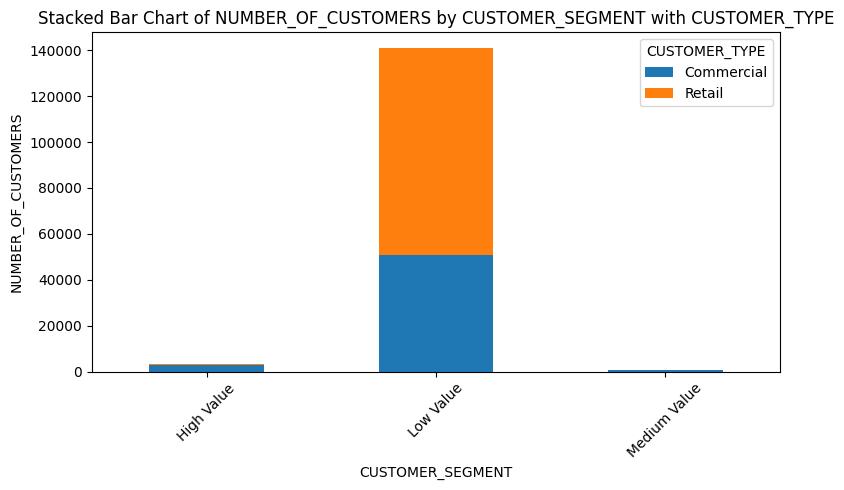

In [17]:
db.plot_stacked_bar(qry,"CUSTOMER_SEGMENT", "NUMBER_OF_CUSTOMERS","CUSTOMER_TYPE" )

`Insights:`
- Commercial Customers: Strong spending potential with 2,875 categorized as high-value.
- Retail Customers: Large low-value base (89,777) but only 502 high-value customers, suggesting upselling opportunities.